In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10

**Loading the dataset**

In [8]:
(train_data_original, _), (test_data_original, _) = cifar10.load_data()

In [9]:
train_data_original = train_data_original.astype('float32') / 255.
test_data_original = test_data_original.astype('float32') / 255.

**Adding Noise to the dataset**

In [10]:
#Gaussian Noise
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

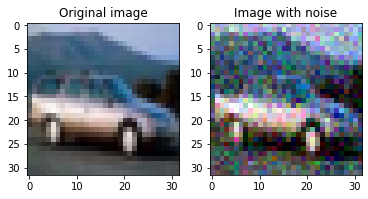

In [11]:
train_data_noisy = add_noise_and_clip_data(train_data_original)
test_data_noisy = add_noise_and_clip_data(test_data_original)

idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_original[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

**Convolutional Architecture**

In [12]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
  
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

**Denoising the** **dataset**

In [30]:
def denoising_autoencoder():
    dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
    conv_block1 = conv_block(dae_inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3, 1)

    deconv_block1 = deconv_block(conv_block5, 256, 3)
    merge1 = Concatenate()([deconv_block1, conv_block3])
    deconv_block2 = deconv_block(merge1, 128, 3)
    merge2 = Concatenate()([deconv_block2, conv_block2])
    deconv_block3 = deconv_block(merge2, 64, 3)
    merge3 = Concatenate()([deconv_block3, conv_block1])
    deconv_block4 = deconv_block(merge3, 32, 3)

    final_deconv = Conv2DTranspose(filters=3,
                        kernel_size=3,
                        padding='same')(deconv_block4)
    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
    
    return Model(dae_inputs, dae_outputs, name='dae')

**Training the model**

In [37]:
  dae = denoising_autoencoder()
  dae.compile(loss='mse', optimizer='adam')
  
  checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

  dae.fit(train_data_noisy,
        train_data_original,
        validation_data=(test_data_noisy, test_data_original),
        epochs=10,
        batch_size=128,
        callbacks=[checkpoint])

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00001: val_loss improved from inf to 0.00483, saving model to best_model.h5
391/391 [==============================] - 9s 23ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00002: val_loss improved from 0.00483 to 0.00225, saving model to best_model.h5
391/391 [==============================] - 9s 22ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00225 to 0.00210, saving model to best_model.h5
391/391 [==============================] - 9s 23ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00004: val_loss improved from 0.00210 to 0.00194, saving model to best_model.h5
391/391 [==============================] - 9s 23ms/step - loss: 0.0022 - val_loss:

**Results**

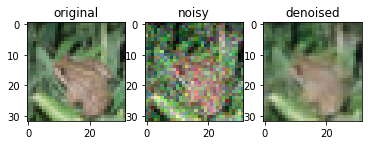

In [38]:
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_original[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()